In [12]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os

In [13]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [14]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [15]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/My_notebook_printemps/network_analysis_functions.py'>


In [16]:
## Définir le endpoint SPARQL
endpoint = "https://ag1khc5dnlqgdc0c.allegrograph.cloud/repositories/Astronauts"


In [17]:
# Requête SPARQL pour récupérer les données des universités
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?item ?itemLabel ?gender ?year ?education ?educationLabel
WHERE {
    SERVICE <https://query.wikidata.org/sparql> {    
        {
            ?item wdt:P106 wd:Q11631  # Astronaute
        } UNION {
            ?item wdt:P101 wd:Q22719  # Astronautics
        } UNION {
            ?item wdt:P106 wd:Q765633  # Aviation
        }
          
        ?item wdt:P31 wd:Q5;  # Any instance of a human
            wdt:P569 ?birthDate;
            wdt:P21 ?gender.
            
        # Ajout des informations sur l'éducation
        OPTIONAL {
            ?item wdt:P69 ?education.
            ?education rdfs:label ?educationLabel.
            FILTER(LANG(?educationLabel) = "en")
        }
        
        BIND(REPLACE(str(?birthDate), "(.*)([0-9]{4})(.*)", "$2") AS ?year)
        FILTER(xsd:integer(?year) > 1900 && xsd:integer(?year) < 2025)
        
        SERVICE wikibase:label { 
            bd:serviceParam wikibase:language "en" 
        }
    }
}
"""

In [23]:
# 1. Exécuter la requête SPARQL
sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()


In [26]:
# Exploration du contenu brut pour comprendre ce qui est retourné
for result in results["results"]["bindings"]:
    print(result)
    break  # Enlève ce break si tu veux tout voir


{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q722667'}, 'gender': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q6581097'}, 'year': {'type': 'literal', 'value': '1951'}, 'education': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q192334'}, 'educationLabel': {'type': 'literal', 'value': 'University of North Carolina at Chapel Hill'}}


In [32]:
# 2. Transformer les résultats en DataFrame (version robuste)
data = []

for result in results["results"]["bindings"]:
    # Utiliser itemLabel si présent, sinon extraire le QID depuis l'URI
    if "itemLabel" in result:
        astronaut = result["itemLabel"]["value"]
    else:
        astronaut_uri = result["item"]["value"]
        astronaut = astronaut_uri.split("/")[-1]  # ex: Q722667

    university = result.get("educationLabel", {}).get("value")

    if astronaut and university:
        data.append((astronaut, university))

df = pd.DataFrame(data, columns=["Astronaut", "University"])
print(df.head())
print(f"{len(df)} astronautes avec une université.")




  Astronaut                                   University
0   Q722667  University of North Carolina at Chapel Hill
1   Q519256                           University of Utah
2   Q440251                     University of Washington
3   Q460161                            Auburn University
4   Q534597           California Institute of Technology
1950 astronautes avec une université.


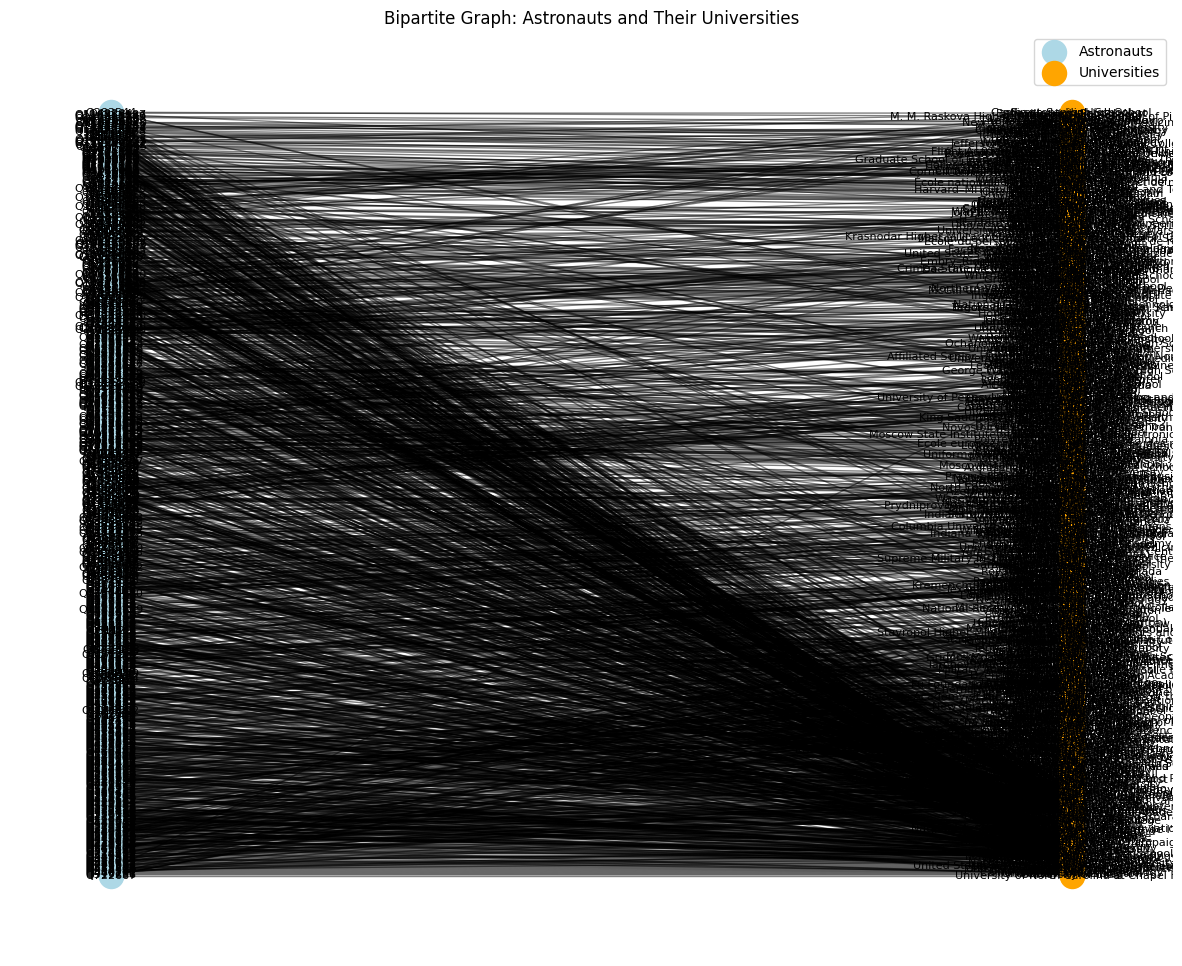

In [43]:
# Générer la position bipartite avec bipartite_layout
pos = nx.bipartite_layout(B, astronauts)

plt.figure(figsize=(15, 12))
nx.draw_networkx_nodes(B, pos, nodelist=astronauts, node_color='lightblue', node_size=300, label='Astronauts')
nx.draw_networkx_nodes(B, pos, nodelist=universities, node_color='orange', node_size=300, label='Universities')
nx.draw_networkx_edges(B, pos, alpha=0.5)
nx.draw_networkx_labels(B, pos, font_size=8)

plt.title("Bipartite Graph: Astronauts and Their Universities")
plt.axis('off')
plt.legend()
plt.show()


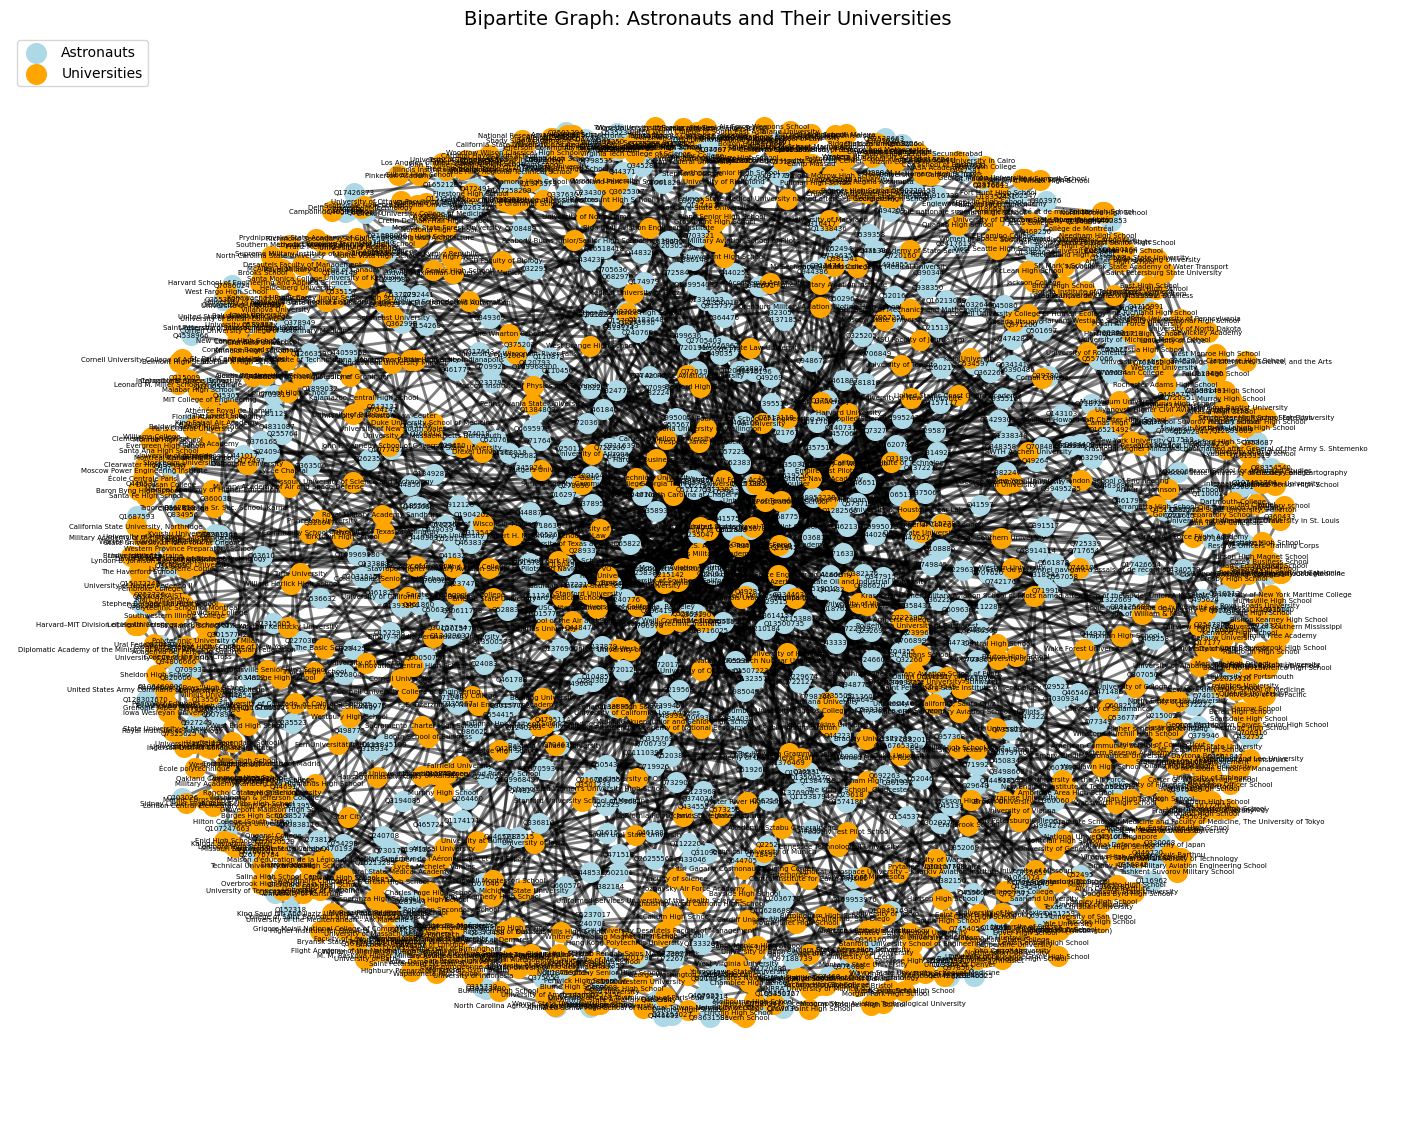

In [45]:
import matplotlib.pyplot as plt
import networkx as nx

# Générer la position avec spring_layout pour une meilleure lisibilité
pos = nx.spring_layout(B, k=0.3, iterations=50)  # Ajuster k et les itérations pour une bonne espacement

# Augmenter la taille de la figure
plt.figure(figsize=(18, 14))

# Définir la taille des nœuds et des étiquettes
node_size_astro = 200  # Taille des nœuds des astronautes
node_size_uni = 200    # Taille des nœuds des universités
font_size = 5         # Taille des étiquettes

# Dessiner les nœuds des astronautes (en bleu clair)
nx.draw_networkx_nodes(B, pos, nodelist=astronauts, node_color='lightblue', node_size=node_size_astro, label='Astronauts')

# Dessiner les nœuds des universités (en orange)
nx.draw_networkx_nodes(B, pos, nodelist=universities, node_color='orange', node_size=node_size_uni, label='Universities')

# Dessiner les arêtes avec épaisseur
nx.draw_networkx_edges(B, pos, alpha=0.5, width=2)

# Dessiner les étiquettes
nx.draw_networkx_labels(B, pos, font_size=font_size)

# Titre du graphique
plt.title("Bipartite Graph: Astronauts and Their Universities", fontsize=14)

# Enlever les axes pour plus de clarté
plt.axis('off')

# Ajouter la légende
plt.legend(loc='upper left', fontsize=10)

# Afficher le graphique
plt.show()


/tmp/ipykernel_293/3536431800.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/jlab-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


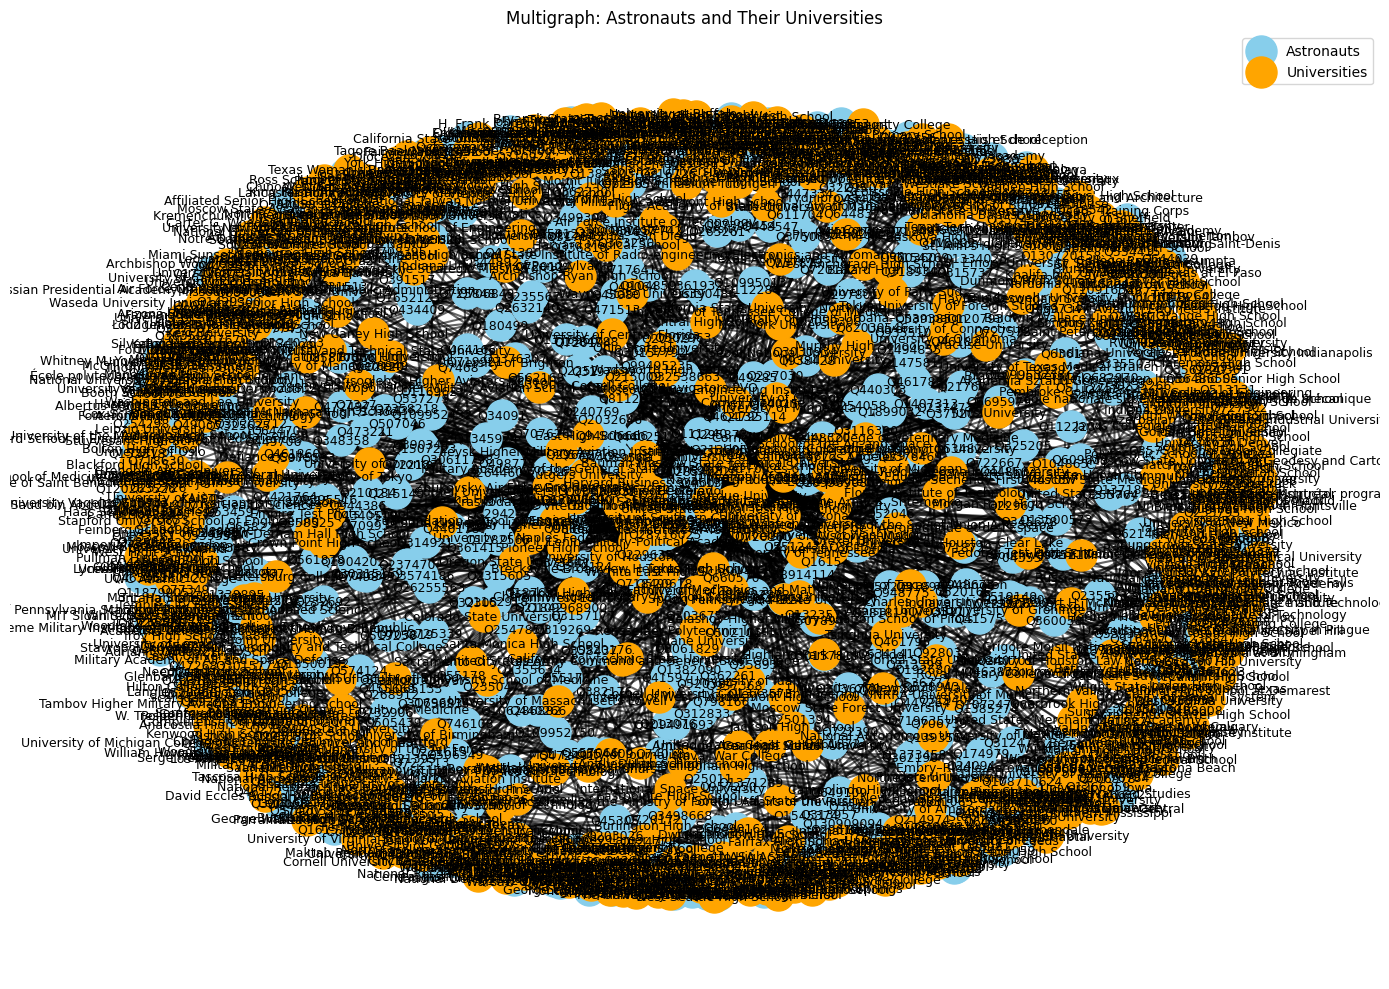

In [48]:
import matplotlib.pyplot as plt
import networkx as nx

# 1. Nettoyage : garder uniquement les lignes avec des universités non nulles
df_clean = df.dropna(subset=['University'])

# 2. Extraire les arêtes (relations astronautes ↔ universités)
edges = list(df_clean[['Astronaut', 'University']].itertuples(index=False, name=None))

# 3. Extraire les nœuds uniques
astronauts = df_clean['Astronaut'].unique().tolist()
universities = df_clean['University'].unique().tolist()

# 4. Créer le MultiGraph
G_multi = nx.MultiGraph()
G_multi.add_nodes_from(astronauts)
G_multi.add_nodes_from(universities)
G_multi.add_edges_from(edges)

# 5. Layout pour placement automatique des nœuds
pos = nx.spring_layout(G_multi, k=0.4, iterations=50)

# 6. Dessiner les nœuds
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_multi, pos, nodelist=astronauts, node_color='skyblue', node_size=500, label='Astronauts')
nx.draw_networkx_nodes(G_multi, pos, nodelist=universities, node_color='orange', node_size=500, label='Universities')

# 7. Dessiner les arêtes
nx.draw_networkx_edges(G_multi, pos, width=1.5, alpha=0.6)

# 8. Ajouter les labels des nœuds
nx.draw_networkx_labels(G_multi, pos, font_size=9)

# 9. Affichage final
plt.title("Multigraph: Astronauts and Their Universities")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()


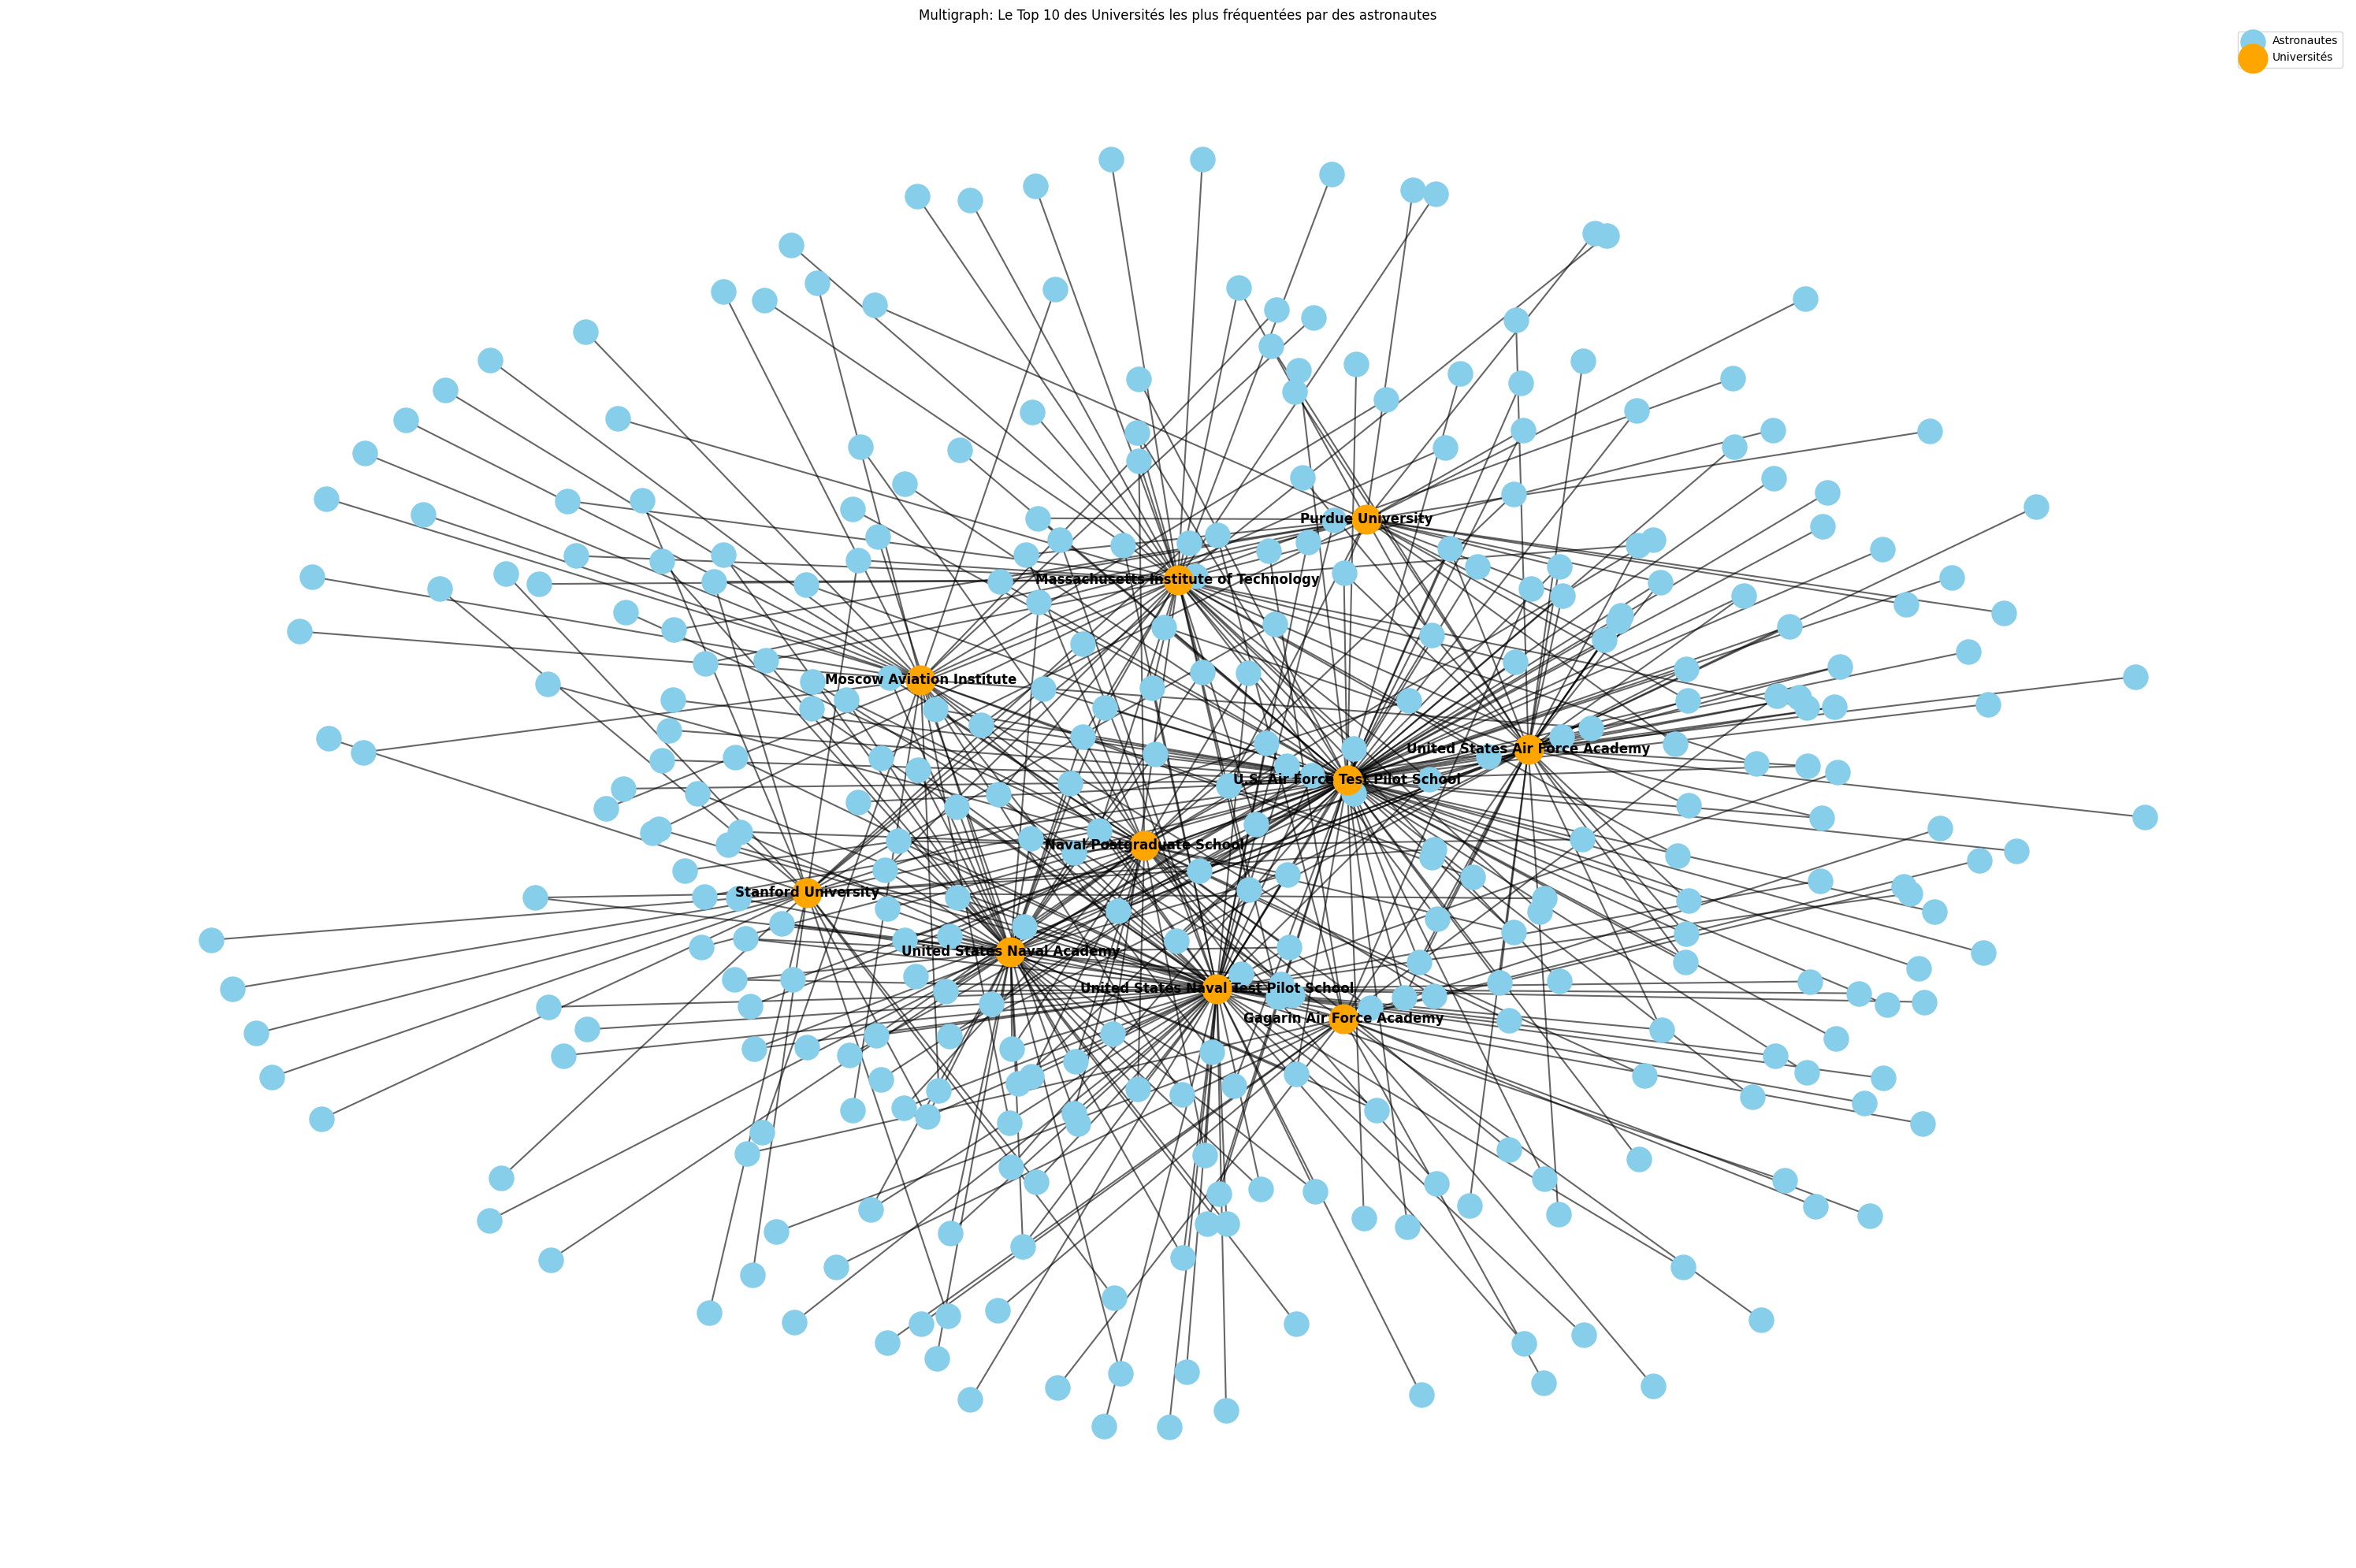

In [72]:
import matplotlib.pyplot as plt
import networkx as nx

# 1. Nettoyage : supprimer les lignes sans université
df_clean = df.dropna(subset=['University'])

# 2. Paramètre : nombre de top universités à conserver
N = 10  # ⇦ Change ce nombre selon la taille que tu veux

# 3. Identifier les N universités les plus fréquentées
top_universities = df_clean['University'].value_counts().head(N).index.tolist()

# 4. Filtrer le DataFrame
df_top = df_clean[df_clean['University'].isin(top_universities)]

# 5. Construire les arêtes et les nœuds
edges = list(df_top[['Astronaut', 'University']].itertuples(index=False, name=None))
astronauts = df_top['Astronaut'].unique().tolist()
universities = df_top['University'].unique().tolist()

# 6. Créer le MultiGraph
G_top = nx.MultiGraph()
G_top.add_nodes_from(astronauts)
G_top.add_nodes_from(universities)
G_top.add_edges_from(edges)


# 7. Layout automatique
pos = nx.spring_layout(G_top, k=0.6, iterations=100, seed=42)

# 8. Dessin du graph
plt.figure(figsize=(30, 20))
nx.draw_networkx_nodes(G_top, pos, nodelist=astronauts, node_color='skyblue', node_size=500, label='Astronautes')
nx.draw_networkx_nodes(G_top, pos, nodelist=universities, node_color='orange', node_size=700, label='Universités')
nx.draw_networkx_edges(G_top, pos, width=1.5, alpha=0.5)

# Labels uniquement pour les universités
labels = {node: node for node in universities}
nx.draw_networkx_labels(G_top, pos, labels=labels, font_size=12, font_color='black', font_weight='bold')

plt.title(f"Multigraph: Le Top {N} des Universités les plus fréquentées par des astronautes")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()




